Cuarto punto:

Primero defininmos la función y su gradiente:

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Definición de la función f(x) y su gradiente
def f(x, c, a_list):
    m, n = len(a_list), len(x)
    dot_products = np.array([np.dot(a, x) for a in a_list])
    log_term1 = np.sum(np.log(np.maximum(1e-10, 1 - dot_products)))
    log_term2 = np.sum(np.log(np.maximum(1e-10, 1 - x**2)))
    return np.dot(c, x) - log_term1 - log_term2

def grad_f(x, c, a_list):
    m, n = len(a_list), len(x)
    grad = c.copy()
    for a in a_list:
        dot_product = np.dot(a, x)
        grad += a / np.maximum(1e-10, 1 - dot_product)
    grad += 2 * x / np.maximum(1e-10, 1 - x**2)
    return grad

Se generan los vectores c y a_{j}:

In [34]:
# Generación de vectores c y a_list
def generate_vectors(m, n):
    c = np.random.randn(n)
    a_list = [np.random.randn(n) for _ in range(m)]
    a_list = [a / np.linalg.norm(a) for a in a_list]  # Normalizar a_j
    return c, a_list

Para la estimación del tamaño de paso que nos asegura la convergencia usamos que este debe ser menor a 2/L donde L es la constante de Lipschitz del gradiente.
Para encontrar L implementamos el siguiente algoritmo:

In [35]:
from numpy.linalg import norm

def estimate_lipschitz_constant(c, a_list, n_samples=1000):
    n = len(c)
    L = 0

    for _ in range(n_samples):
        # Generar dos puntos aleatorios en el dominio [-0.99, 0.99]
        x = np.random.uniform(-0.99, 0.99, n)
        y = np.random.uniform(-0.99, 0.99, n)

        # Calcular los gradientes
        grad_x = grad_f(x, c, a_list)
        grad_y = grad_f(y, c, a_list)

        # Calcular las normas de las diferencias
        grad_diff_norm = norm(grad_x - grad_y)
        point_diff_norm = norm(x - y)

        # Actualizar la estimación de L
        if point_diff_norm > 0:
            L = max(L, grad_diff_norm / point_diff_norm)

    return L

# Ejemplo de uso
n, m = 5000, 2000
c, a_list = generate_vectors(m, n)

L_estimate = estimate_lipschitz_constant(c, a_list)
print(f"Estimación de la constante de Lipschitz L: {L_estimate}")
alpha = 2/L_estimate - 0.2/L_estimate
print(f"alpha: {alpha}")

Estimación de la constante de Lipschitz L: 2584134800.095481
alpha: 6.965580897457408e-10


Restringimos x a un dominio adecuado:

In [36]:
# Función auxiliar para restringir x
def clip_x(x):
    return np.clip(x, -0.99, 0.99)

A continuación se encuentran los codigos de cada uno de los algoritmos, en el siguiente orden:

* Gradiente con tamaño de paso constante
* Gradiente con backtracking
* Gradiente con backtracking y la condición de wolfe
* Metodo de Newton

In [37]:
# Método del gradiente con tamaño de paso constante
def gradient_descent(x0, c, a_list, alpha, max_iter, epsilon):
    x = clip_x(x0.copy())
    f_values = [f(x, c, a_list)]
    start_time = time()

    for i in range(max_iter):
        grad = grad_f(x, c, a_list)
        if np.linalg.norm(grad) < epsilon:
            break
        x = clip_x(x - alpha * grad)
        f_values.append(f(x, c, a_list))

    return x, f_values, time() - start_time

In [38]:
# Método del gradiente con backtracking
def gradient_descent_backtracking(x0, c, a_list, alpha, beta, max_iter, epsilon):
    x = clip_x(x0.copy())
    f_values = [f(x, c, a_list)]
    start_time = time()

    for i in range(max_iter):
        grad = grad_f(x, c, a_list)
        if np.linalg.norm(grad) < epsilon:
            break

        t = 1.0
        while f(clip_x(x - t * grad), c, a_list) > f(x, c, a_list) - alpha * t * np.dot(grad, grad):
            t *= beta

        x = clip_x(x - t * grad)
        f_values.append(f(x, c, a_list))

    return x, f_values, time() - start_time


In [39]:
# Método del gradiente con backtracking y condición de Wolfe
def gradient_descent_wolfe(x0, c, a_list, alpha, beta, c1, c2, max_iter, epsilon):
    x = clip_x(x0.copy())
    f_values = [f(x, c, a_list)]
    start_time = time()

    for i in range(max_iter):
        grad = grad_f(x, c, a_list)
        if np.linalg.norm(grad) < epsilon:
            break

        t = 1.0
        while True:
            new_x = clip_x(x - t * grad)
            if f(new_x, c, a_list) <= f(x, c, a_list) - c1 * t * np.dot(grad, grad):
                new_grad = grad_f(new_x, c, a_list)
                if np.dot(new_grad, -grad) >= c2 * np.dot(grad, -grad):
                    break
            t *= beta

        x = new_x
        f_values.append(f(x, c, a_list))

    return x, f_values, time() - start_time


In [40]:
# Método de Newton
def newton_method(x0, c, a_list, max_iter, epsilon):
    x = clip_x(x0.copy())
    f_values = [f(x, c, a_list)]
    start_time = time()

    for i in range(max_iter):
        grad = grad_f(x, c, a_list)
        if np.linalg.norm(grad) < epsilon:
            break

        # Cálculo de la matriz Hessiana (aproximación numérica)
        h = 1e-8
        hessian = np.zeros((len(x), len(x)))
        for j in range(len(x)):
            x_plus = x.copy()
            x_plus[j] += h
            grad_plus = grad_f(x_plus, c, a_list)
            hessian[:, j] = (grad_plus - grad) / h

        # Resolver el sistema lineal para obtener la dirección de Newton
        direction = np.linalg.solve(hessian, -grad)

        # Actualizar x
        x = clip_x(x + direction)
        f_values.append(f(x, c, a_list))

    return x, f_values, time() - start_time

Inicializamos los métodos con los siguientes parametros:

* (alpha, betha) son (0.5,0.8), ( 0.8,0.3), (0.5,0.5) para el algoritmo de gradiente desendiente con backtracking
* (alpha, betha, c1,c2) = (0.5, 0.8, 0.1, 0.9), (0.8, 0.3, 0.05, 0.5) y (0.5, 0.5, 0.07, 0.5) para gradiente descendiente con la condición de wolfe.


In [41]:
# Configuración del problema
n, m = 5000, 2000
c, a_list = generate_vectors(m, n)
x0 = np.zeros(n)
max_iter = 1000
epsilon = 1e-6

# Ejecutar los métodos
methods = {
    "Gradiente (paso constante)": lambda: gradient_descent(x0, c, a_list, alpha, max_iter, epsilon),

    "Gradiente (backtracking) 1": lambda: gradient_descent_backtracking(x0, c, a_list, 0.5, 0.8, max_iter, epsilon),
    "Gradiente (backtracking) 2": lambda: gradient_descent_backtracking(x0, c, a_list, 0.8, 0.3, max_iter, epsilon),
    "Gradiente (backtracking) 3": lambda: gradient_descent_backtracking(x0, c, a_list, 0.5, 0.5, max_iter, epsilon),

    # "Gradiente (Wolfe) 1": lambda: gradient_descent_wolfe(x0, c, a_list, 0.5, 0.8, 0.1, 0.9, max_iter, epsilon),
    # "Gradiente (Wolfe) 2": lambda: gradient_descent_wolfe(x0, c, a_list, 0.8, 0.3, 0.05, 0.5, max_iter, epsilon),
    # "Gradiente (Wolfe) 3": lambda: gradient_descent_wolfe(x0, c, a_list, 0.5, 0.5, 0.07, 0.5, max_iter, epsilon),

    # "Newton": lambda: newton_method(x0, c, a_list, max_iter, epsilon)
}

results = {}

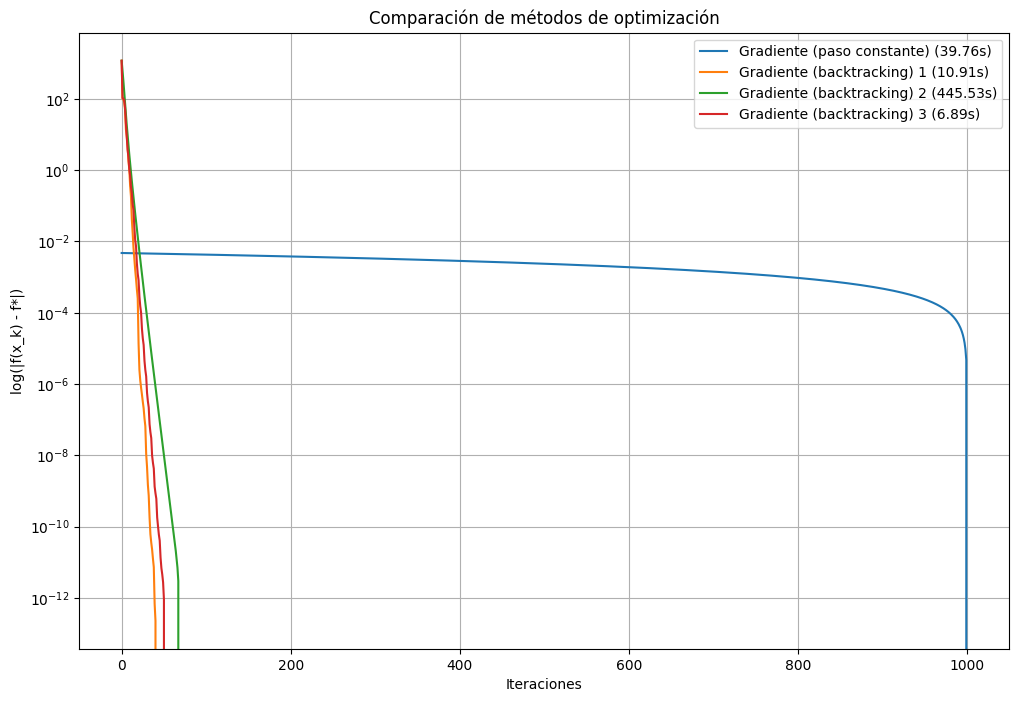

Resultados por método:
Gradiente (paso constante):
  Tiempo de ejecución: 39.76 segundos
  Valor final de f: -0.004754
  Estimación de f*: -0.004754
  Número de iteraciones: 1001

Gradiente (backtracking) 1:
  Tiempo de ejecución: 10.91 segundos
  Valor final de f: -1183.936682
  Estimación de f*: -1183.936682
  Número de iteraciones: 42

Gradiente (backtracking) 2:
  Tiempo de ejecución: 445.53 segundos
  Valor final de f: -1183.936682
  Estimación de f*: -1183.936682
  Número de iteraciones: 1001

Gradiente (backtracking) 3:
  Tiempo de ejecución: 6.89 segundos
  Valor final de f: -1183.936682
  Estimación de f*: -1183.936682
  Número de iteraciones: 55

Mejor estimación global de f*: -1183.936682


In [42]:
for method_name, method_func in methods.items():
    x_opt, f_values, execution_time = method_func()
    f_star = min(f_values)  # Estimación del mínimo para este método
    results[method_name] = (x_opt, f_values, execution_time, f_star)

# Graficar resultados
plt.figure(figsize=(12, 8))
for method, (x_opt, f_values, time, f_star) in results.items():
    plt.semilogy(range(len(f_values)), [abs(fv - f_star) for fv in f_values], label=f"{method} ({time:.2f}s)")

plt.xlabel("Iteraciones")
plt.ylabel("log(|f(x_k) - f*|)")
plt.title("Comparación de métodos de optimización")
plt.legend()
plt.grid(True)
plt.show()

print("Resultados por método:")
for method, (x_opt, f_values, time, f_star) in results.items():
    print(f"{method}:")
    print(f"  Tiempo de ejecución: {time:.2f} segundos")
    print(f"  Valor final de f: {f_values[-1]:.6f}")
    print(f"  Estimación de f*: {f_star:.6f}")
    print(f"  Número de iteraciones: {len(f_values)}")
    print()

# Encontrar el mejor f* global
global_f_star = min(result[3] for result in results.values())
print(f"Mejor estimación global de f*: {global_f_star:.6f}")